## This code is to implement theta sweeps in a continuous attractor network of place cells. For simplicity, we consider a 1D ring of 100 neurons, saying the animal is running in a circular track. But we are going to display the network in a linear track instead, for visualization purposes. 

In [1]:
import numpy as np
import brainpy.math as bm
import matplotlib.pyplot as plt
from network import PC_cell
from scipy.ndimage import gaussian_filter
import seaborn as sns
from scipy.signal import hilbert
from scipy import signal

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/zilong/anaconda3/envs/HDPhasePrecession/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_zero_phase(filtered_lfp):
    """
    get the zero phase of the filtered lfp using hilbert transform
    """
    analytic_signal = hilbert(filtered_lfp)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    # wrap the instantaneous_phase to -pi and pi
    instantaneous_phase = np.mod(instantaneous_phase + np.pi, 2 * np.pi) - np.pi
    # find phase of 0 and mark all of them as a red point on the plot
    zero_phase = np.where(
        np.logical_and(instantaneous_phase > -3.14, instantaneous_phase < -3.0)
    )[0]

    # if successive zero phase is less than 10, only keep the first one
    splits = np.split(zero_phase, np.where(np.diff(zero_phase) > 30)[0] + 1)

    # rremove empty in splits
    splits = [split for split in splits if len(split) > 0]

    zero_phase_index = np.array([split[0] for split in splits])

    return zero_phase_index

def bandpassfilter(data, lowcut=5, highcut=11, fs=500):
    """
    band pass filter of the signal
    Created by Zilong, 30/08/2021
    """
    lowcut = 5
    highcut = 11
    order = 5
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype="band")
    filtereddata = signal.filtfilt(b, a, data)

    return filtereddata

def generate_traj_hd(x0, v, T, var=1):
    x = []
    xt = x0
    for i in range(T):
        xt = xt + v * (1 + var*np.random.randn(1)) * bm.dt
        if xt > np.pi:
            xt -= 2 * np.pi
        if xt < -np.pi:
            xt += 2 * np.pi
        x.append(xt)
    return np.array(x)
 

In [3]:
bm.set_dt(1.)

np.random.seed(111)
bm.random.seed(0)


PC_net = PC_cell(num=200, 
                noise_stre=0.0, 
                tau=5., tau_v=100., 
                k=1., mbar=25, a=0.5, A=3., J0=4., 
                z_min=-bm.pi, z_max=bm.pi)

def run_PCNet(i, Actual_pos, velocity_gain):  # 20 x size

    T_theta = 100 #ms
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta
    theta_phase = theta_phase * 2 * np.pi - np.pi
    #calculate TheataModulator at time step i
    ThetaModulation = 1+(0.1+0.2*velocity_gain)*bm.cos(theta_phase)
    # ThetaModulation = 1
    PC_net.step_run(i, Actual_pos, ThetaModulation)
    Internal_pos = PC_net.center
    bump_activity = PC_net.r
   
    return Internal_pos, bump_activity, theta_phase, ThetaModulation

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## 1, visualize theta sweeps

100%|██████████| 3200/3200 [00:00<00:00, 14028.61it/s]
/tmp/ipykernel_1220692/2329582332.py:99: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


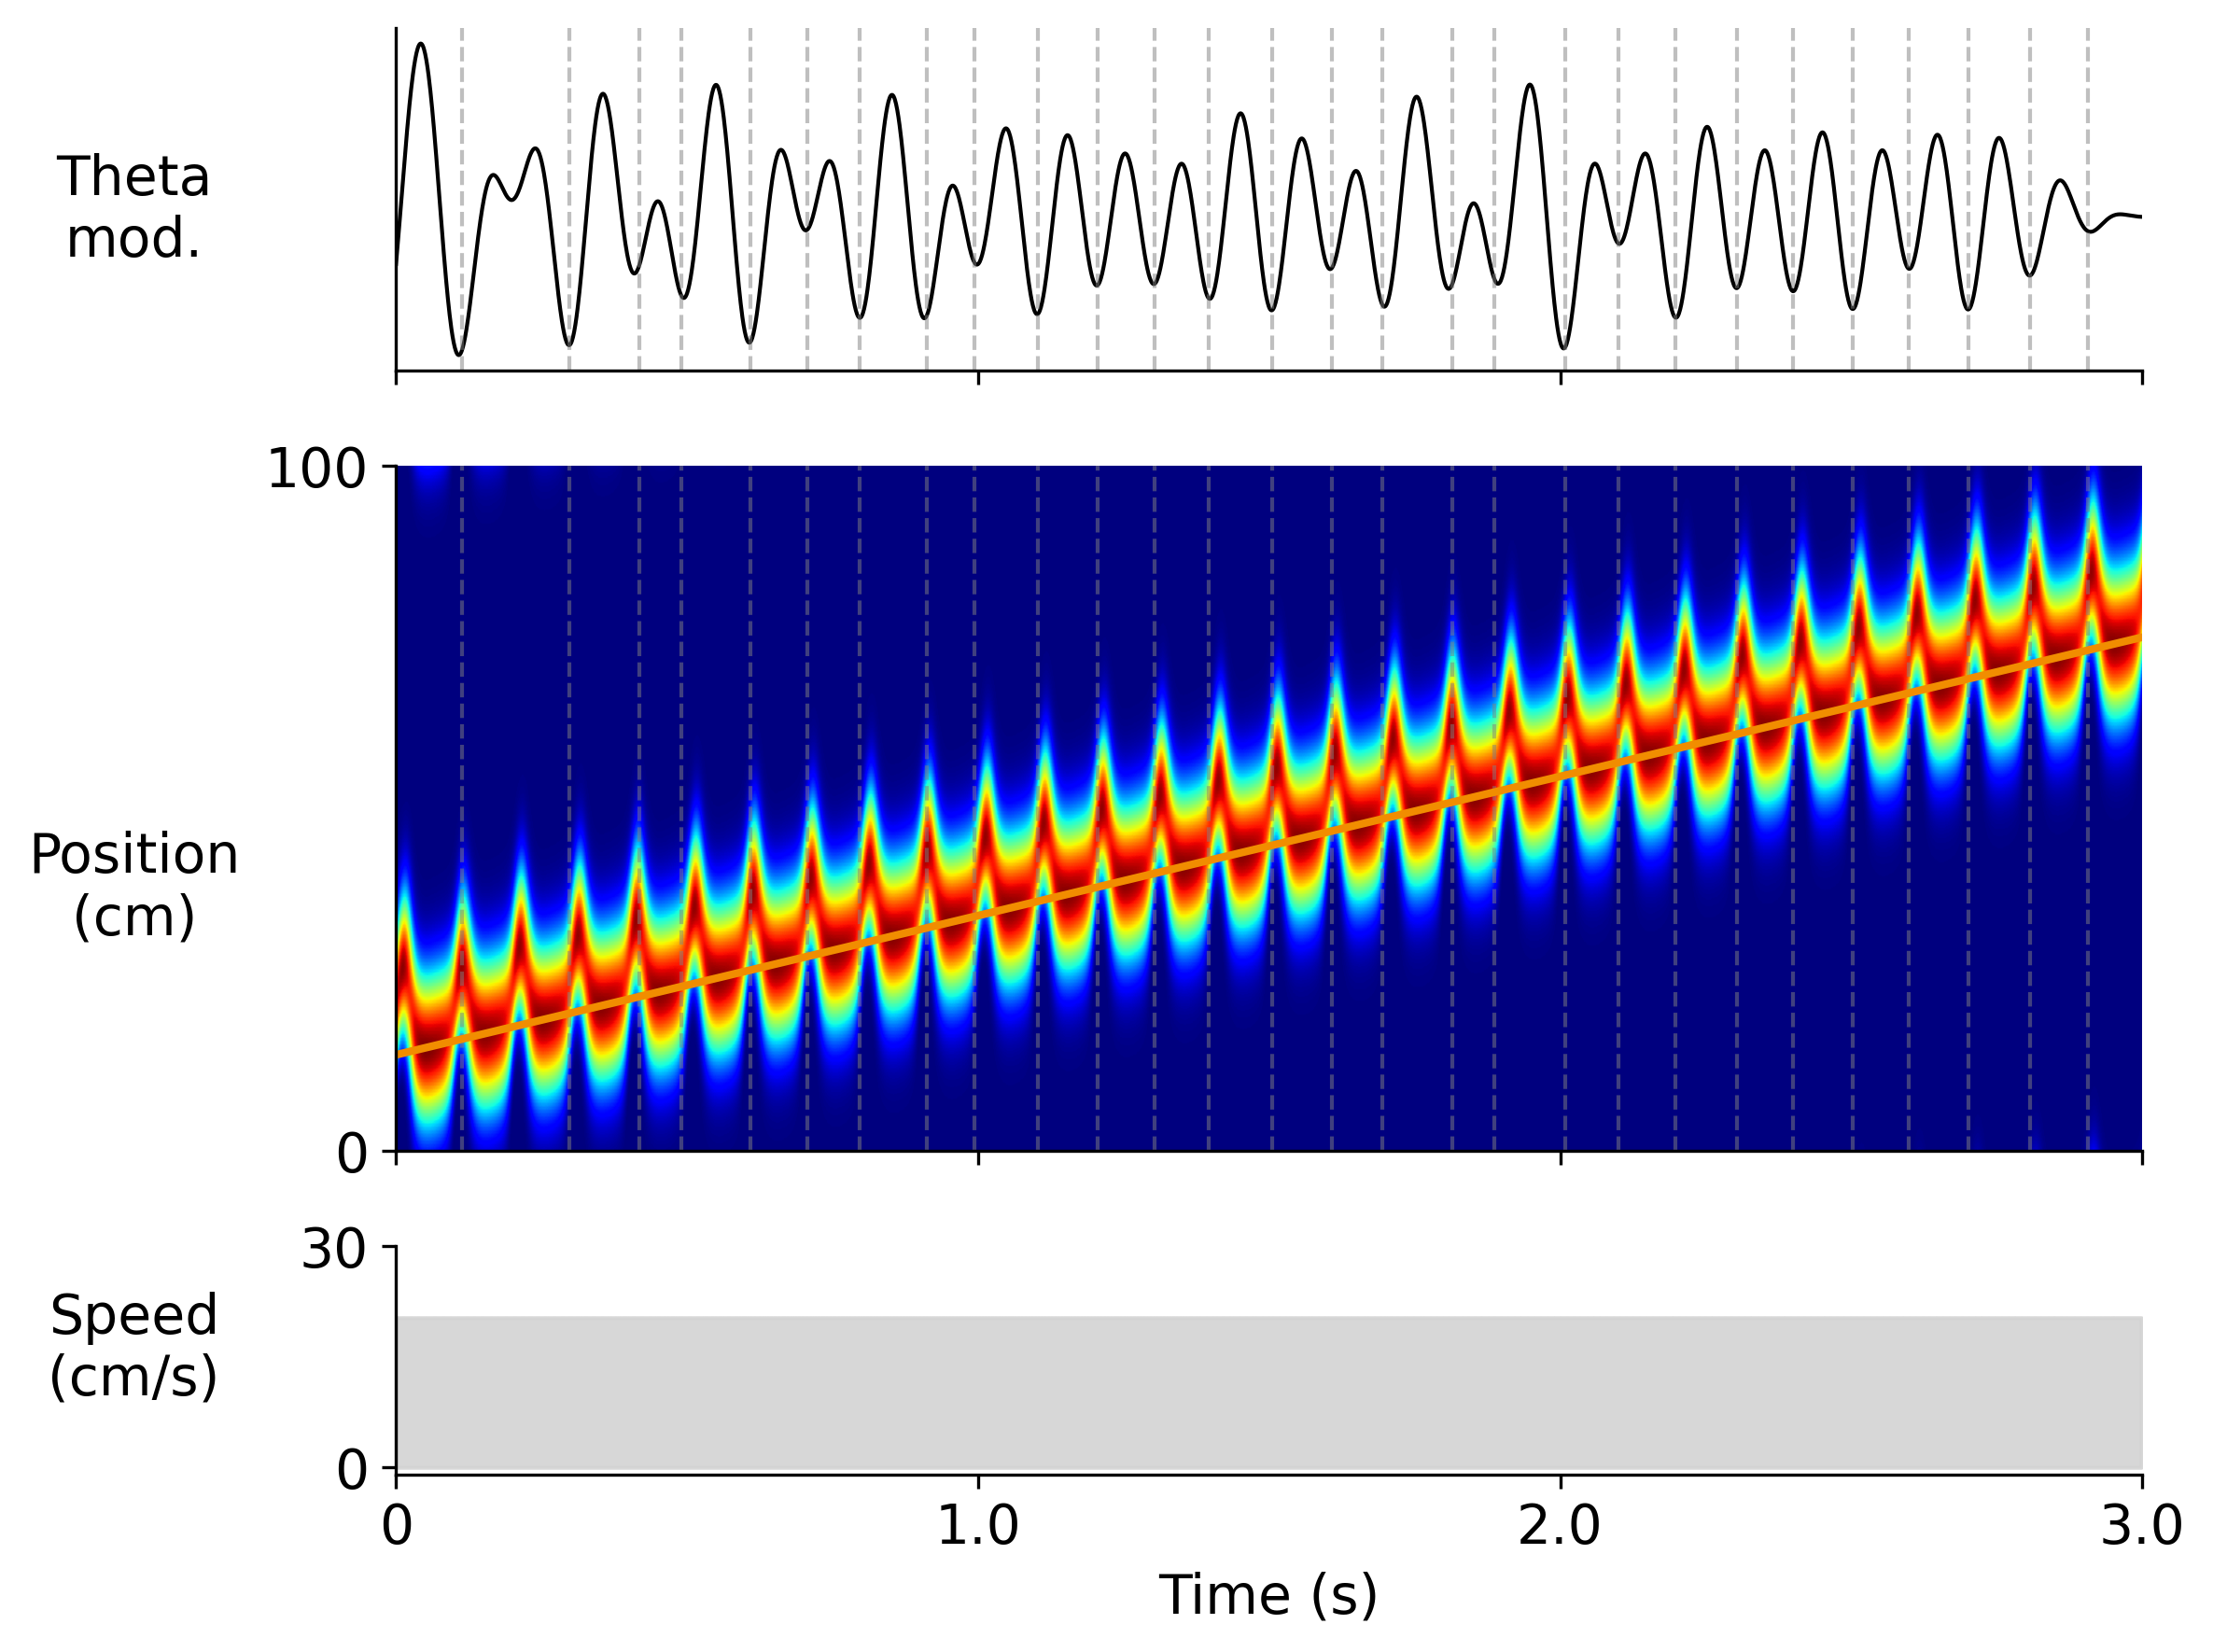

In [6]:
np.random.seed(111)
bm.random.seed(0)

numT = 3200
time_steps = np.arange(numT)
#chaging position, mimicking the animal turning
velocity_gain = 1.3
Actual_pos = velocity_gain*bm.pi*bm.arange(numT)/numT
#wrap to 0 to 2pi
Actual_pos = bm.mod(Actual_pos, 2*bm.pi) - 0.8*bm.pi
velocity_gain = np.ones_like(Actual_pos)*velocity_gain
bump_center, bump_activity, theta_phase, theta_mod = bm.for_loop(run_PCNet, (time_steps, Actual_pos, velocity_gain), progress_bar=True)
mean_bump_activity = np.mean(bump_activity, axis=1)


start = 200
end = 3000+start

#plot
t_plot = time_steps[start:end]
Actual_pos_plot = Actual_pos[start:end]
bump_activity_plot = bump_activity[start:end]
theta_mod_plot = theta_mod[start:end]
theta_phase_plot = theta_phase[start:end]
mean_bump_activity_plot = mean_bump_activity[start:end]

labelsize=10
ticksize=8

fig, axes = plt.subplots(
    3,
    1,
    figsize=(8, 6),
    sharex=True,
    constrained_layout=True,
    gridspec_kw={"height_ratios": [1.5, 3, 1]},
    dpi=300,
)


ax = axes[0]
# plot theta modulation
# ax.plot(t_plot, mean_bump_activity_plot, color='black', lw=1)
#bandpass filter max_bump_activity_plot
theta = bandpassfilter(mean_bump_activity_plot, lowcut=5, highcut=11, fs=1000)
zero_phase_index = get_zero_phase(theta)

#plot the filtered theta
ax.plot(t_plot, theta, color='black', lw=1)

ax.set_yticks([])

# add multiple vertical lines to indicate the zero phase
for i in zero_phase_index:
    axes[0].axvline(x=t_plot[i], color='grey', linestyle='--', linewidth=1, alpha=0.5)
    axes[1].axvline(x=t_plot[i], color='grey', linestyle='--', linewidth=1, alpha=0.5)

ax = axes[1]
#plot population sweeps

# imshow and smooth
ax.imshow(bump_activity_plot.T*100, aspect='auto', extent=[t_plot[0], t_plot[-1], -bm.pi, bm.pi], cmap='jet', origin='lower')

#plot the head direction as a line
ax.plot(t_plot, Actual_pos_plot, color='#F18D00', lw=2)

#yticks
ax.set_yticks([-bm.pi, bm.pi])
ax.set_yticklabels([0, 100])

ax = axes[2]
#plot speed
speed = np.diff(Actual_pos_plot)/bm.dt *1000
#/2*np.pi * 100 to cm
speed = speed/(2*np.pi)* 100
#plot speed with fill_between
# ax.plot(t_plot[:-1], speed, color='black', lw=2)
ax.fill_between(t_plot[:-1], speed, color='lightgrey', linewidth=1, alpha=0.9)

ax.set_yticks([0, 30])
ax.set_xticks([0+start, 1000+start, 2000+start, 3000+start])
ax.set_xticklabels([0, 1.0, 2.0, 3.0])

#================================================================================================

axes[0].set_ylabel("Theta\nmod.", fontsize=14, rotation=0)
axes[1].set_ylabel("Position\n(cm)", fontsize=14, rotation=0)
axes[2].set_ylabel("Speed\n(cm/s)", fontsize=14, rotation=0)
axes[2].set_xlabel("Time (s)", fontsize=14)

for ax in axes:
    sns.despine(ax=ax)
    #align ylabels vertically
    ax.yaxis.set_label_coords(-0.15, 0.3)  # Shift labels left (adjust as needed)
    #ticklabels fontsize as 12
    ax.tick_params(axis="both", labelsize=14)


plt.tight_layout()

## 2, make an animation

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import brainpy.math as bm

np.random.seed(111)
bm.random.seed(0)

# Set up style
sns.set_style("white")
cmap = plt.cm.jet
cmap.set_bad("white", alpha=1.0)

# Simulation parameters
numT = 3200
downsample_factor = 10  # Downsample 1000Hz → 100Hz (keep every 10th sample)
time_steps = np.arange(numT)
velocity_gain = 1.3

# Generate head direction trajectory
Actual_pos = velocity_gain * bm.pi * bm.arange(numT) / numT
Actual_pos = bm.mod(Actual_pos, 2 * bm.pi) - 0.8 * bm.pi
velocity_gain = np.ones_like(Actual_pos) * velocity_gain

# Run simulation
bump_center, bump_activity, theta_phase, theta_mod = bm.for_loop(run_PCNet, (time_steps, Actual_pos, velocity_gain), progress_bar=True)
mean_bump_activity = np.mean(bump_activity, axis=1)


# Define plot range
start = 200  # Adjusted for downsampling (200 → 20)
end = numT  # Scaled accordingly

# Extract plotting data
t_plot_raw = time_steps[start:end]
Actual_pos_plot = Actual_pos[start:end]
bump_activity_plot = bump_activity[start:end]
theta_mod_plot = theta_mod[start:end]
theta_phase_plot = theta_phase[start:end]
mean_bump_activity_plot = mean_bump_activity[start:end]

# Bandpass filter theta modulation (downsampled)
theta = bandpassfilter(mean_bump_activity_plot, lowcut=5, highcut=11, fs=1000)
zero_phase_index = get_zero_phase(theta)

# **Downsample Data (1000Hz → 100Hz)**
t_plot = t_plot_raw[::downsample_factor]
theta = theta[::downsample_factor]
Actual_pos_plot = Actual_pos_plot[::downsample_factor]
bump_activity_plot = bump_activity_plot[::downsample_factor]
theta_mod_plot = theta_mod_plot[::downsample_factor]
theta_phase_plot = theta_phase_plot[::downsample_factor]
mean_bump_activity_plot = mean_bump_activity_plot[::downsample_factor]

# Compute speed (downsampled)
speed = np.diff(Actual_pos_plot) / bm.dt * 1000 / downsample_factor # Convert to speed
speed = speed / (2 * np.pi) * 100  # Convert to cm/s


100%|██████████| 3200/3200 [00:00<00:00, 14066.01it/s]


Frame: 1 / 300


/tmp/ipykernel_1465304/4199265187.py:82: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  theta_dot.set_data(t_plot[frame - 1], theta[frame - 1])
/tmp/ipykernel_1465304/4199265187.py:88: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  position_dot.set_data(t_plot[frame - 1], Actual_pos_plot[frame - 1])
/tmp/ipykernel_1465304/4199265187.py:91: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  speed_dot.set_data(t_plot[frame - 1], speed[frame - 1])


Frame: 2 / 300
Frame: 3 / 300
Frame: 4 / 300
Frame: 5 / 300
Frame: 6 / 300
Frame: 7 / 300
Frame: 8 / 300
Frame: 9 / 300
Frame: 10 / 300
Frame: 11 / 300
Frame: 12 / 300
Frame: 13 / 300
Frame: 14 / 300
Frame: 15 / 300
Frame: 16 / 300
Frame: 17 / 300
Frame: 18 / 300
Frame: 19 / 300
Frame: 20 / 300
Frame: 21 / 300
Frame: 22 / 300
Frame: 23 / 300
Frame: 24 / 300
Frame: 25 / 300
Frame: 26 / 300
Frame: 27 / 300
Frame: 28 / 300
Frame: 29 / 300
Frame: 30 / 300
Frame: 31 / 300
Frame: 32 / 300
Frame: 33 / 300
Frame: 34 / 300
Frame: 35 / 300
Frame: 36 / 300
Frame: 37 / 300
Frame: 38 / 300
Frame: 39 / 300
Frame: 40 / 300
Frame: 41 / 300
Frame: 42 / 300
Frame: 43 / 300
Frame: 44 / 300
Frame: 45 / 300
Frame: 46 / 300
Frame: 47 / 300
Frame: 48 / 300
Frame: 49 / 300
Frame: 50 / 300
Frame: 51 / 300
Frame: 52 / 300
Frame: 53 / 300
Frame: 54 / 300
Frame: 55 / 300
Frame: 56 / 300
Frame: 57 / 300
Frame: 58 / 300
Frame: 59 / 300
Frame: 60 / 300
Frame: 61 / 300
Frame: 62 / 300
Frame: 63 / 300
Frame: 64 / 300


/tmp/ipykernel_1465304/4199265187.py:82: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  theta_dot.set_data(t_plot[frame - 1], theta[frame - 1])
/tmp/ipykernel_1465304/4199265187.py:88: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  position_dot.set_data(t_plot[frame - 1], Actual_pos_plot[frame - 1])
/tmp/ipykernel_1465304/4199265187.py:91: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  speed_dot.set_data(t_plot[frame - 1], speed[frame - 1])


Frame: 102 / 300
Frame: 103 / 300
Frame: 104 / 300
Frame: 105 / 300
Frame: 106 / 300
Frame: 107 / 300
Frame: 108 / 300
Frame: 109 / 300
Frame: 110 / 300
Frame: 111 / 300
Frame: 112 / 300
Frame: 113 / 300
Frame: 114 / 300
Frame: 115 / 300
Frame: 116 / 300
Frame: 117 / 300
Frame: 118 / 300
Frame: 119 / 300
Frame: 120 / 300
Frame: 121 / 300
Frame: 122 / 300
Frame: 123 / 300
Frame: 124 / 300
Frame: 125 / 300
Frame: 126 / 300
Frame: 127 / 300
Frame: 128 / 300
Frame: 129 / 300
Frame: 130 / 300
Frame: 131 / 300
Frame: 132 / 300
Frame: 133 / 300
Frame: 134 / 300
Frame: 135 / 300
Frame: 136 / 300
Frame: 137 / 300
Frame: 138 / 300
Frame: 139 / 300
Frame: 140 / 300
Frame: 141 / 300
Frame: 142 / 300
Frame: 143 / 300
Frame: 144 / 300
Frame: 145 / 300
Frame: 146 / 300
Frame: 147 / 300
Frame: 148 / 300
Frame: 149 / 300
Frame: 150 / 300
Frame: 151 / 300
Frame: 152 / 300
Frame: 153 / 300
Frame: 154 / 300
Frame: 155 / 300
Frame: 156 / 300
Frame: 157 / 300
Frame: 158 / 300
Frame: 159 / 300
Frame: 160 / 3

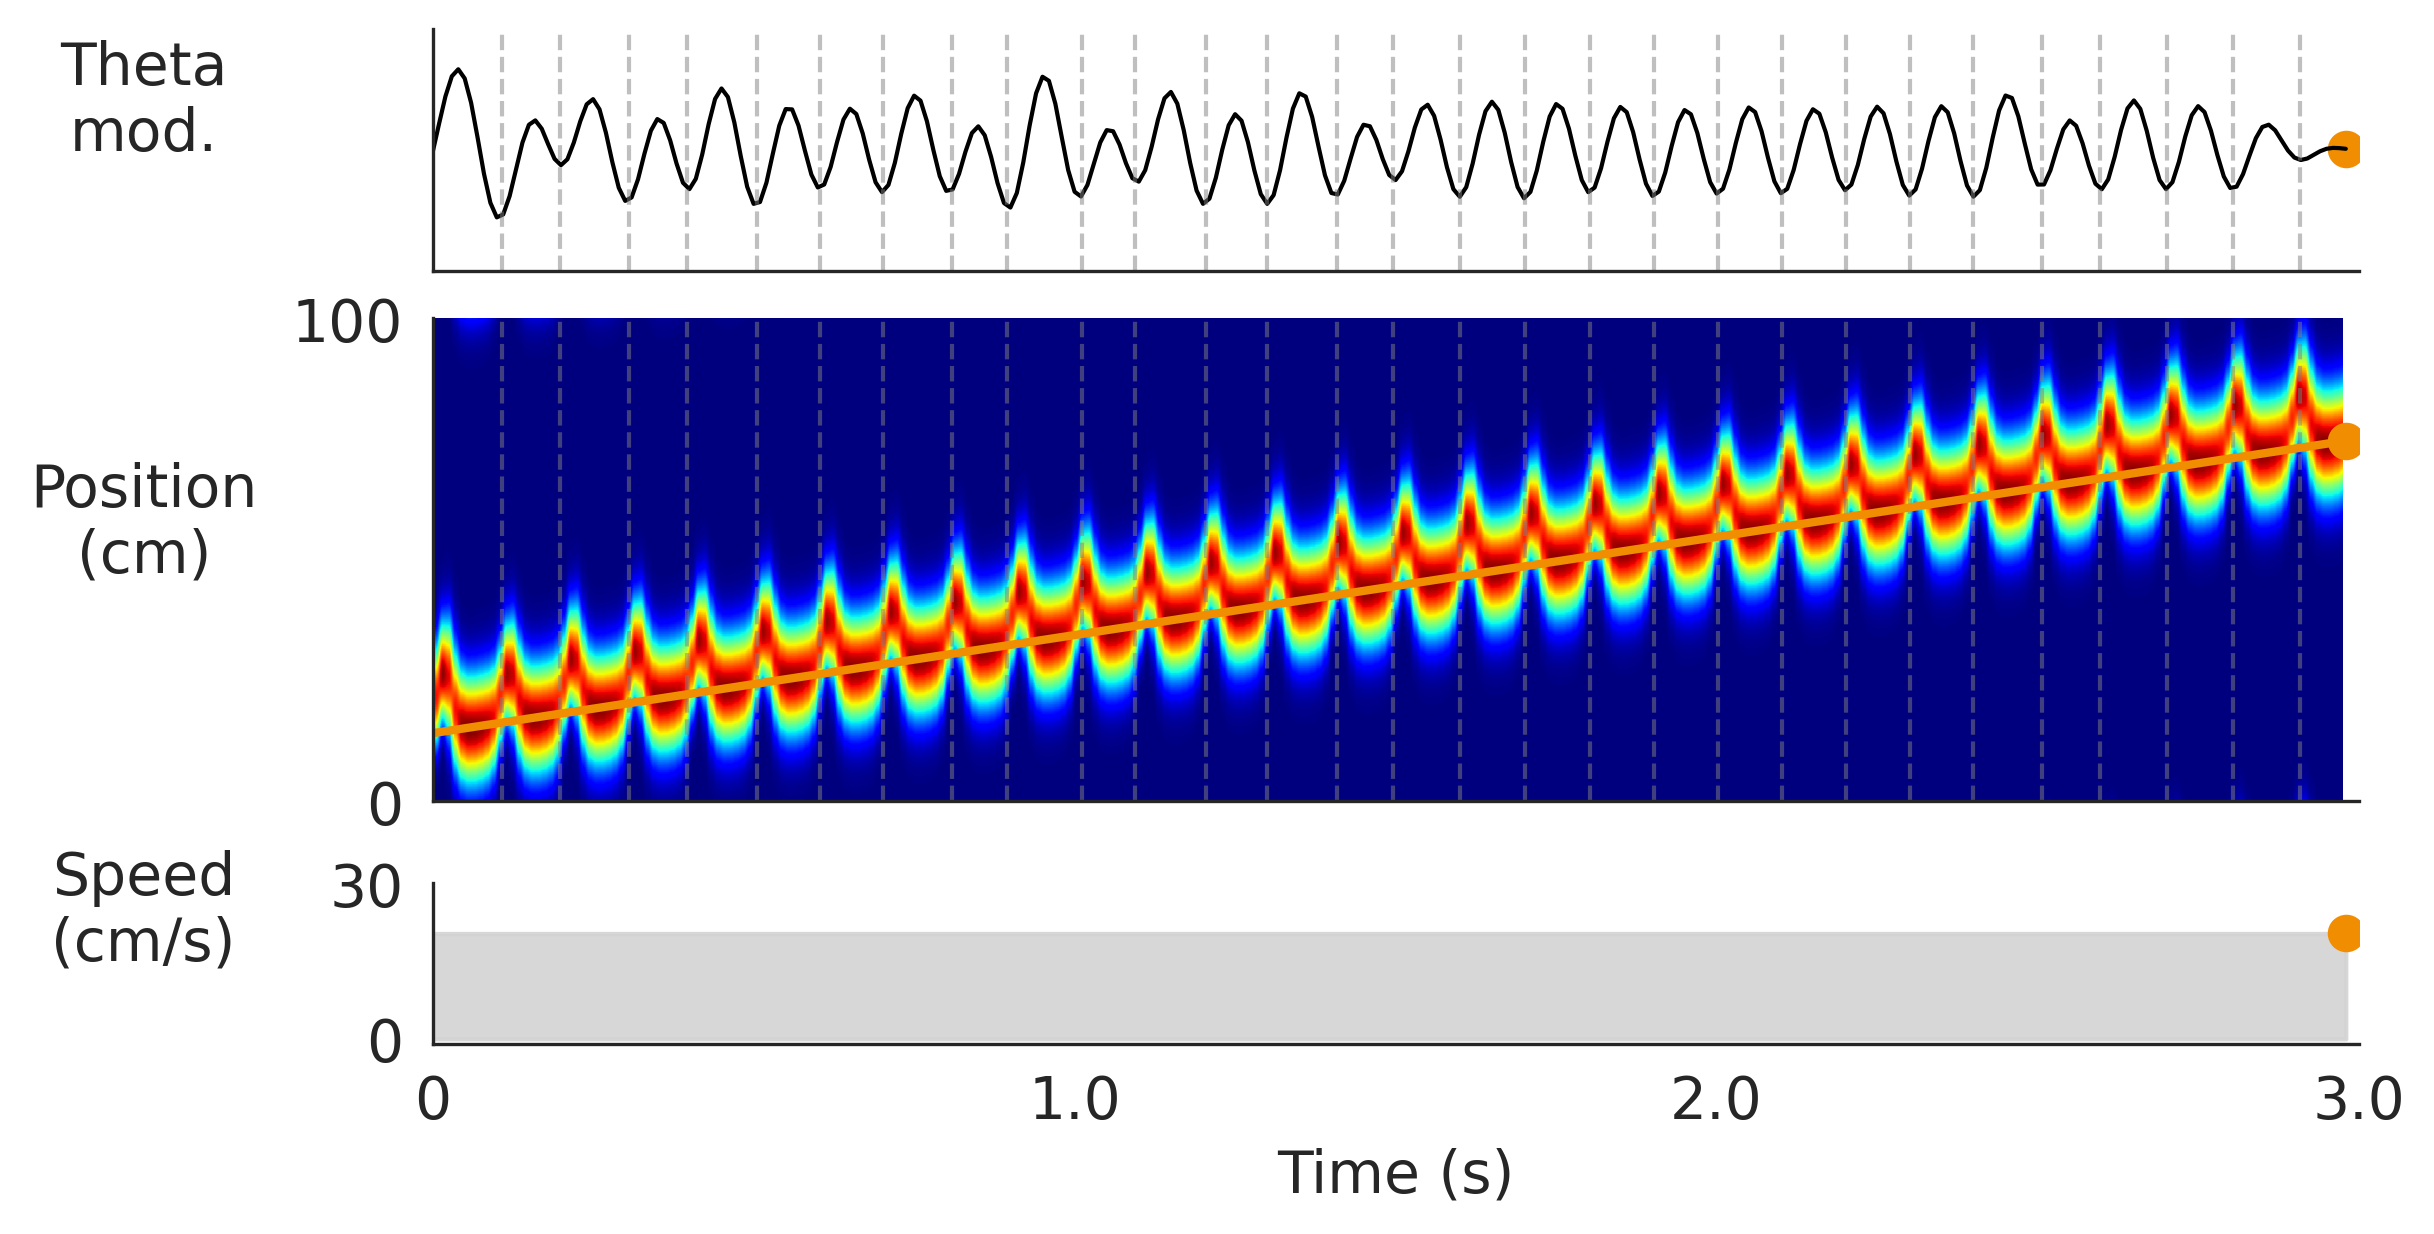

In [70]:

# **Set up figure**
fig, axes = plt.subplots(
    3, 1, figsize=(8, 4), sharex=True, constrained_layout=True,
    gridspec_kw={"height_ratios": [1.5, 3, 1]}, dpi=300
)

# **Initialize plots**
# Theta modulation plot
axes[0].set_ylim([-1.5*np.max(np.abs(theta)), 1.5*np.max(np.abs(theta))])
axes[0].set_yticks([])

theta_dot, = axes[0].plot([], [], 'o', color="#F18D00", markersize=8)

filtered_theta_line, = axes[0].plot([], [], color='black', lw=1)
# theta_zero_lines = [axes[0].axvline(x=0, color='grey', linestyle="--", linewidth=1, alpha=0.5) for _ in zero_phase_index]

#plot phase lines
for i in zero_phase_index:
    axes[0].axvline(x=t_plot_raw[i], color='grey', linestyle='--', linewidth=1, alpha=0.5)
    axes[1].axvline(x=t_plot_raw[i], color='grey', linestyle='--', linewidth=1, alpha=0.5)

# Population activity plot (heatmap)
vmin = np.min(bump_activity_plot) * 100
vmax = np.max(bump_activity_plot) * 100
posmin = -bm.pi
posmax = bm.pi
im = axes[1].imshow(np.zeros((bump_activity_plot.shape[1], len(t_plot))),
                    aspect='auto', extent=[t_plot[0], t_plot[-1], posmin, posmax], cmap='jet', origin='lower',
                    vmin=vmin, vmax=vmax)

trajectory, = axes[1].plot([], [], color="#F18D00", lw=2)
position_dot, = axes[1].plot([], [], 'o', color="#F18D00", markersize=8)

axes[1].set_yticks([-bm.pi, bm.pi])
axes[1].set_yticklabels([0, 100])

# # Zero phase lines in population activity plot
# pop_zero_lines = [axes[1].axvline(x=0, color='grey', linestyle="--", linewidth=1, alpha=0.5) for _ in zero_phase_index]

# Speed plot
speed_fill = axes[2].fill_between(t_plot[:-1], speed, color="lightgrey", linewidth=1, alpha=0.9)
speed_dot, = axes[2].plot([], [], 'o', color="#F18D00", markersize=8)

axes[2].set_xticks([0 + start, 1000 + start, 2000 + start, 3000 + start])
axes[2].set_xticklabels([0, 1.0, 2.0, 3.0])

# Axis labels
axes[0].set_ylabel("Theta\nmod.", fontsize=14, rotation=0)
axes[1].set_ylabel("Position\n(cm)", fontsize=14, rotation=0)
axes[2].set_ylabel("Speed\n(cm/s)", fontsize=14, rotation=0)
axes[2].set_xlabel("Time (s)", fontsize=14)

axes[2].set_xticks([start, 1000 + start, 2000 + start, 3000 + start])
axes[2].set_xticklabels([0, 1.0, 2.0, 3.0])
axes[2].set_yticks([0, 30])

for ax in axes:
    sns.despine(ax=ax)
    ax.yaxis.set_label_coords(-0.15, 0.45)
    ax.tick_params(axis="both", labelsize=14)


# **Animation update function**
def update(frame):
    if frame == 0:
        return filtered_theta_line, trajectory, speed_dot, im

    # Update theta modulation line
    filtered_theta_line.set_data(t_plot[:frame], theta[:frame])

    
    print(f"Frame: {frame} / {len(t_plot)}")
    
    # Update population activity heatmap
    # im.set_data(bump_activity_plot[:frame].T * 100)
    fixed_snapshot = np.full((bump_activity_plot.shape[1], bump_activity_plot.shape[0]), np.nan)
    fixed_snapshot[:, :frame] = bump_activity_plot[:frame].T * 100
    im.clip = (vmin, vmax)
    im.set_data(fixed_snapshot)

    #update the theta modulation dot
    theta_dot.set_data(t_plot[frame - 1], theta[frame - 1])
    
    # Update position line
    trajectory.set_data(t_plot[:frame], Actual_pos_plot[:frame])

    # Update position dot
    position_dot.set_data(t_plot[frame - 1], Actual_pos_plot[frame - 1])
    
    # Update speed dot
    speed_dot.set_data(t_plot[frame - 1], speed[frame - 1])
    

    return filtered_theta_line, trajectory, speed_dot, im

# Slow down animation speed
playback_slowdown = 10
# **Create animation**
ani = animation.FuncAnimation(
    fig, update, frames=len(t_plot), interval=downsample_factor*playback_slowdown, blit=True  # Adjusted interval for 100Hz
)

# **Save animation as MP4**
ani.save("/home/zilong/Desktop/HDPhasePrecession/PrezFigures/theta_sequences_model.gif",
         writer="ffmpeg", dpi=300)

plt.show()


Frame: 1 / 300
Frame: 2 / 300
Frame: 3 / 300
Frame: 4 / 300
Frame: 5 / 300
Frame: 6 / 300
Frame: 7 / 300
Frame: 8 / 300
Frame: 9 / 300
Frame: 10 / 300
Frame: 11 / 300
Frame: 12 / 300
Frame: 13 / 300
Frame: 14 / 300
Frame: 15 / 300
Frame: 16 / 300


/tmp/ipykernel_1220692/4150999881.py:71: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  pos_dot.set_xdata(actual_pos_normalized[frame])


Frame: 17 / 300
Frame: 18 / 300
Frame: 19 / 300
Frame: 20 / 300
Frame: 21 / 300
Frame: 22 / 300
Frame: 23 / 300
Frame: 24 / 300
Frame: 25 / 300
Frame: 26 / 300
Frame: 27 / 300
Frame: 28 / 300
Frame: 29 / 300
Frame: 30 / 300
Frame: 31 / 300
Frame: 32 / 300
Frame: 33 / 300
Frame: 34 / 300
Frame: 35 / 300
Frame: 36 / 300
Frame: 37 / 300
Frame: 38 / 300
Frame: 39 / 300
Frame: 40 / 300
Frame: 41 / 300
Frame: 42 / 300
Frame: 43 / 300
Frame: 44 / 300
Frame: 45 / 300
Frame: 46 / 300
Frame: 47 / 300
Frame: 48 / 300
Frame: 49 / 300
Frame: 50 / 300
Frame: 51 / 300
Frame: 52 / 300
Frame: 53 / 300
Frame: 54 / 300
Frame: 55 / 300
Frame: 56 / 300
Frame: 57 / 300
Frame: 58 / 300
Frame: 59 / 300
Frame: 60 / 300
Frame: 61 / 300
Frame: 62 / 300
Frame: 63 / 300
Frame: 64 / 300
Frame: 65 / 300
Frame: 66 / 300
Frame: 67 / 300
Frame: 68 / 300
Frame: 69 / 300
Frame: 70 / 300
Frame: 71 / 300
Frame: 72 / 300
Frame: 73 / 300
Frame: 74 / 300
Frame: 75 / 300
Frame: 76 / 300
Frame: 77 / 300
Frame: 78 / 300
Frame: 7

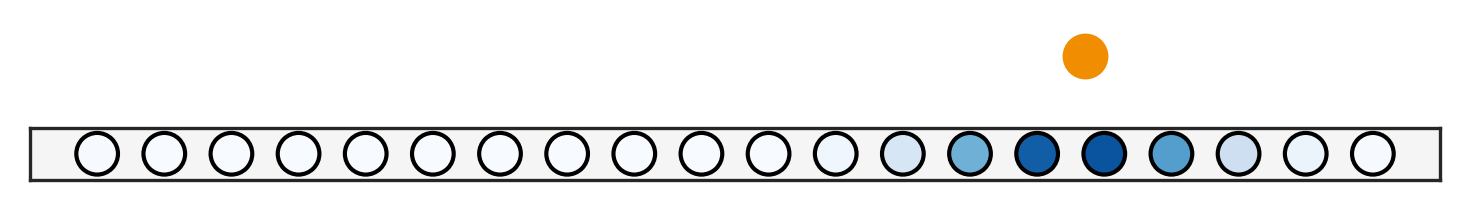

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import brainpy.math as bm

np.random.seed(111)

# Simulation parameters
numT = 300  # Number of time steps
num_neurons = 200
downsample_factor = 10  # Downsample neurons (200 → 20)
num_downsampled_neurons = num_neurons // downsample_factor  # 20 neurons

# **Evenly Downsample bump activity** from (300, 200) → (300, 20)
bump_activity_downsampled = bump_activity_plot[:, np.linspace(0, num_neurons - 1, num_downsampled_neurons, dtype=int)]

# **Normalize Actual_pos_plot to match the neuron index range (0 to 19)**
actual_pos_normalized = np.interp(
    Actual_pos_plot, 
    (-np.pi, np.pi), 
    (0, num_downsampled_neurons - 1)
)

# **Set up figure (horizontal layout)**
fig, axes = plt.subplots(2, 1, figsize=(5, 0.8), dpi=300, height_ratios=[1, 1])  # Top: Position | Bottom: Activity

axes[1].set_ylim(-1, 1)  # Scatter plot stays centered
axes[1].set_xlim(-1, num_downsampled_neurons)  # Align neuron indices on x-axis
axes[0].set_xlim(0, num_downsampled_neurons - 1)  # Ensure red dot stays visible

# **Set light grey background for axes[0]**
axes[1].set_facecolor("whitesmoke")

# **Remove axes for a clean visualization**
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

axes[0].set_frame_on(False)

# **Initialize scatter plot (Now horizontal)**
vmin = np.min(bump_activity_downsampled) 
vmax = np.max(bump_activity_downsampled) 
scatter = axes[1].scatter(
    np.arange(num_downsampled_neurons),  # X-coordinates for neurons (flipped)
    np.zeros(num_downsampled_neurons),  # Y-coordinates fixed at 0
    c=np.zeros(num_downsampled_neurons),  # Initial colors
    cmap="Blues",  # Colormap
    s=100,  # Marker size
    edgecolors="black",
    vmin=vmin, vmax=vmax  # Color scale
)

# **Initialize position marker (Red dot for position tracking)**
pos_dot, = axes[0].plot(actual_pos_normalized[0], 0, 'o', color="#F18D00", markersize=10)

plt.tight_layout()

# **Animation update function**
def update(frame):
    if frame == 0:
        return scatter, pos_dot

    print(f"Frame: {frame} / {numT}")
    
    # Update scatter colors based on bump activity at this time step
    scatter.set_array(bump_activity_downsampled[frame, :])

    # Update position dot (Red marker)
    pos_dot.set_xdata(actual_pos_normalized[frame])

    return scatter, pos_dot

# **Create animation**
ani = animation.FuncAnimation(
    fig, update, frames=numT, interval=100, blit=True
)

# **Save animation as GIF**
ani.save("/home/zilong/Desktop/HDPhasePrecession/PrezFigures/bump_activity_sweep.gif",
         writer="ffmpeg", dpi=300)

plt.show()


## Animation phase precession of a single neuron

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import brainpy.math as bm

np.random.seed(111)

# Set up style
sns.set_style("white")
cmap = plt.cm.jet
cmap.set_bad("white", alpha=1.0)

# Simulation parameters
numT = 3200
downsample_factor = 10  # Downsample 1000Hz → 100Hz (keep every 10th sample)
time_steps = np.arange(numT)
velocity_gain = 1.3

# Generate head direction trajectory
Actual_pos = velocity_gain * bm.pi * bm.arange(numT) / numT
Actual_pos = bm.mod(Actual_pos, 2 * bm.pi) - 0.8 * bm.pi
velocity_gain = np.ones_like(Actual_pos) * velocity_gain

# Run simulation
bump_center, bump_activity, theta_phase, theta_mod = bm.for_loop(run_PCNet, (time_steps, Actual_pos, velocity_gain), progress_bar=True)
mean_bump_activity = np.mean(bump_activity, axis=1)


# Define plot range
start = 200  # Adjusted for downsampling (200 → 20)
end = numT  # Scaled accordingly

# Extract plotting data
t_plot_raw = time_steps[start:end]
Actual_pos_plot = Actual_pos[start:end]
bump_activity_plot = bump_activity[start:end]
theta_mod_plot = theta_mod[start:end]
theta_phase_plot = theta_phase[start:end]
mean_bump_activity_plot = mean_bump_activity[start:end]

# Bandpass filter theta modulation (downsampled)
theta = bandpassfilter(mean_bump_activity_plot, lowcut=5, highcut=11, fs=1000)
zero_phase_index = get_zero_phase(theta)

# **Downsample Data (1000Hz → 100Hz)**
t_plot = t_plot_raw[::downsample_factor]
theta = theta[::downsample_factor]
Actual_pos_plot = Actual_pos_plot[::downsample_factor]
bump_activity_plot = bump_activity_plot[::downsample_factor]
theta_mod_plot = theta_mod_plot[::downsample_factor]
theta_phase_plot = theta_phase_plot[::downsample_factor]
mean_bump_activity_plot = mean_bump_activity_plot[::downsample_factor]

# Compute speed (downsampled)
speed = np.diff(Actual_pos_plot) / bm.dt * 1000 / downsample_factor # Convert to speed
speed = speed / (2 * np.pi) * 100  # Convert to cm/s


100%|██████████| 3200/3200 [00:00<00:00, 13941.96it/s]


### A schematic understanding of phase precession in the model

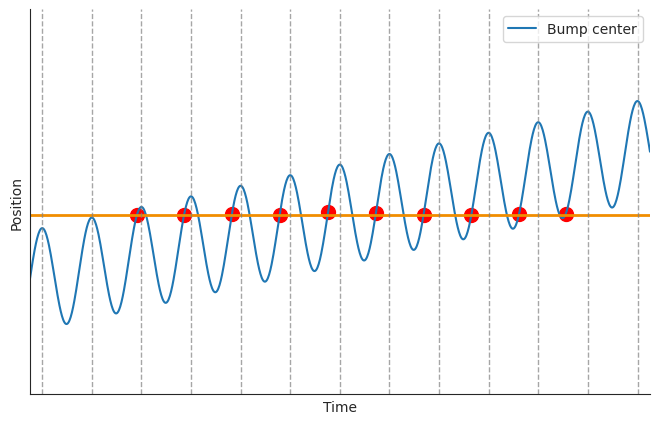

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import argrelextrema

# Define parameters
time_schematic = np.linspace(0, 5, 2000)  # Time from 0 to 5 seconds
frequency = 5  # Hz
slope_factor = 2  # Reduce slope for slower ramping
position_schematic = (-3/4)*np.pi + (slope_factor/2)*np.pi * time_schematic/3 + np.sin(2 * np.pi * frequency * time_schematic)  # Slower ramping

# Find crossing points where position crosses y = 0
crossing_indices = np.where(np.diff(np.sign(position_schematic)))[0] + 1
crossing_times = time_schematic[crossing_indices]
crossing_positions = position_schematic[crossing_indices]

# **Keep only the odd zero crossings (first per cycle)**
odd_crossing_times = crossing_times[::2]
odd_crossing_positions = crossing_positions[::2]

# Find peaks (local maxima)
peak_indices = argrelextrema(position_schematic, np.greater)[0]
peak_times = time_schematic[peak_indices]
peak_positions = position_schematic[peak_indices]

# Create the plot
plt.figure(figsize=(8, 5), dpi=100)
plt.plot(time_schematic, position_schematic, label="Bump center")

# Mark only the **odd** zero crossings
plt.scatter(odd_crossing_times, odd_crossing_positions, color='red', s=100)  # Red points at selected zero crossings

# Horizontal reference line at y=0
plt.axhline(y=0, color='#F18D00', linestyle='-', linewidth=2)  

# Add vertical lines at the **peaks**
for t in peak_times:
    plt.axvline(x=t, color='grey', linestyle='--', linewidth=1, alpha=0.7)

# Styling
sns.despine()
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend()

# Remove y and x ticks
plt.yticks([])
plt.xticks([])
plt.xlim(1, 3.5)

# Show plot
plt.show()


### do the animation

/tmp/ipykernel_1516998/3229972164.py:173: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_1516998/3229972164.py:188: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  pos_dot.set_xdata(actual_pos_normalized[frame])


Frame: 1 / 300
Frame: 2 / 300
Frame: 3 / 300
Frame: 4 / 300
Frame: 5 / 300
Frame: 6 / 300
Frame: 7 / 300
Frame: 8 / 300
Frame: 9 / 300
Frame: 10 / 300
Frame: 11 / 300
Frame: 12 / 300
Frame: 13 / 300
Frame: 14 / 300
Frame: 15 / 300
Frame: 16 / 300
Frame: 17 / 300
Frame: 18 / 300
Frame: 19 / 300
Frame: 20 / 300
Frame: 21 / 300
Frame: 22 / 300
Frame: 23 / 300
Frame: 24 / 300
Frame: 25 / 300
Frame: 26 / 300
Frame: 27 / 300
Frame: 28 / 300
Frame: 29 / 300
Frame: 30 / 300
Frame: 31 / 300
Frame: 32 / 300
Frame: 33 / 300
Frame: 34 / 300
Frame: 35 / 300
Frame: 36 / 300
Frame: 37 / 300
Frame: 38 / 300
Frame: 39 / 300
Frame: 40 / 300
Frame: 41 / 300
Frame: 42 / 300
Frame: 43 / 300
Frame: 44 / 300
Frame: 45 / 300
Frame: 46 / 300
Frame: 47 / 300
Frame: 48 / 300
Frame: 49 / 300
Frame: 50 / 300
Frame: 51 / 300
Frame: 52 / 300
Frame: 53 / 300
Frame: 54 / 300
Frame: 55 / 300
Frame: 56 / 300
Frame: 57 / 300
Frame: 58 / 300
Frame: 59 / 300
Frame: 60 / 300
Frame: 61 / 300
Frame: 62 / 300
Frame: 63 / 300
F

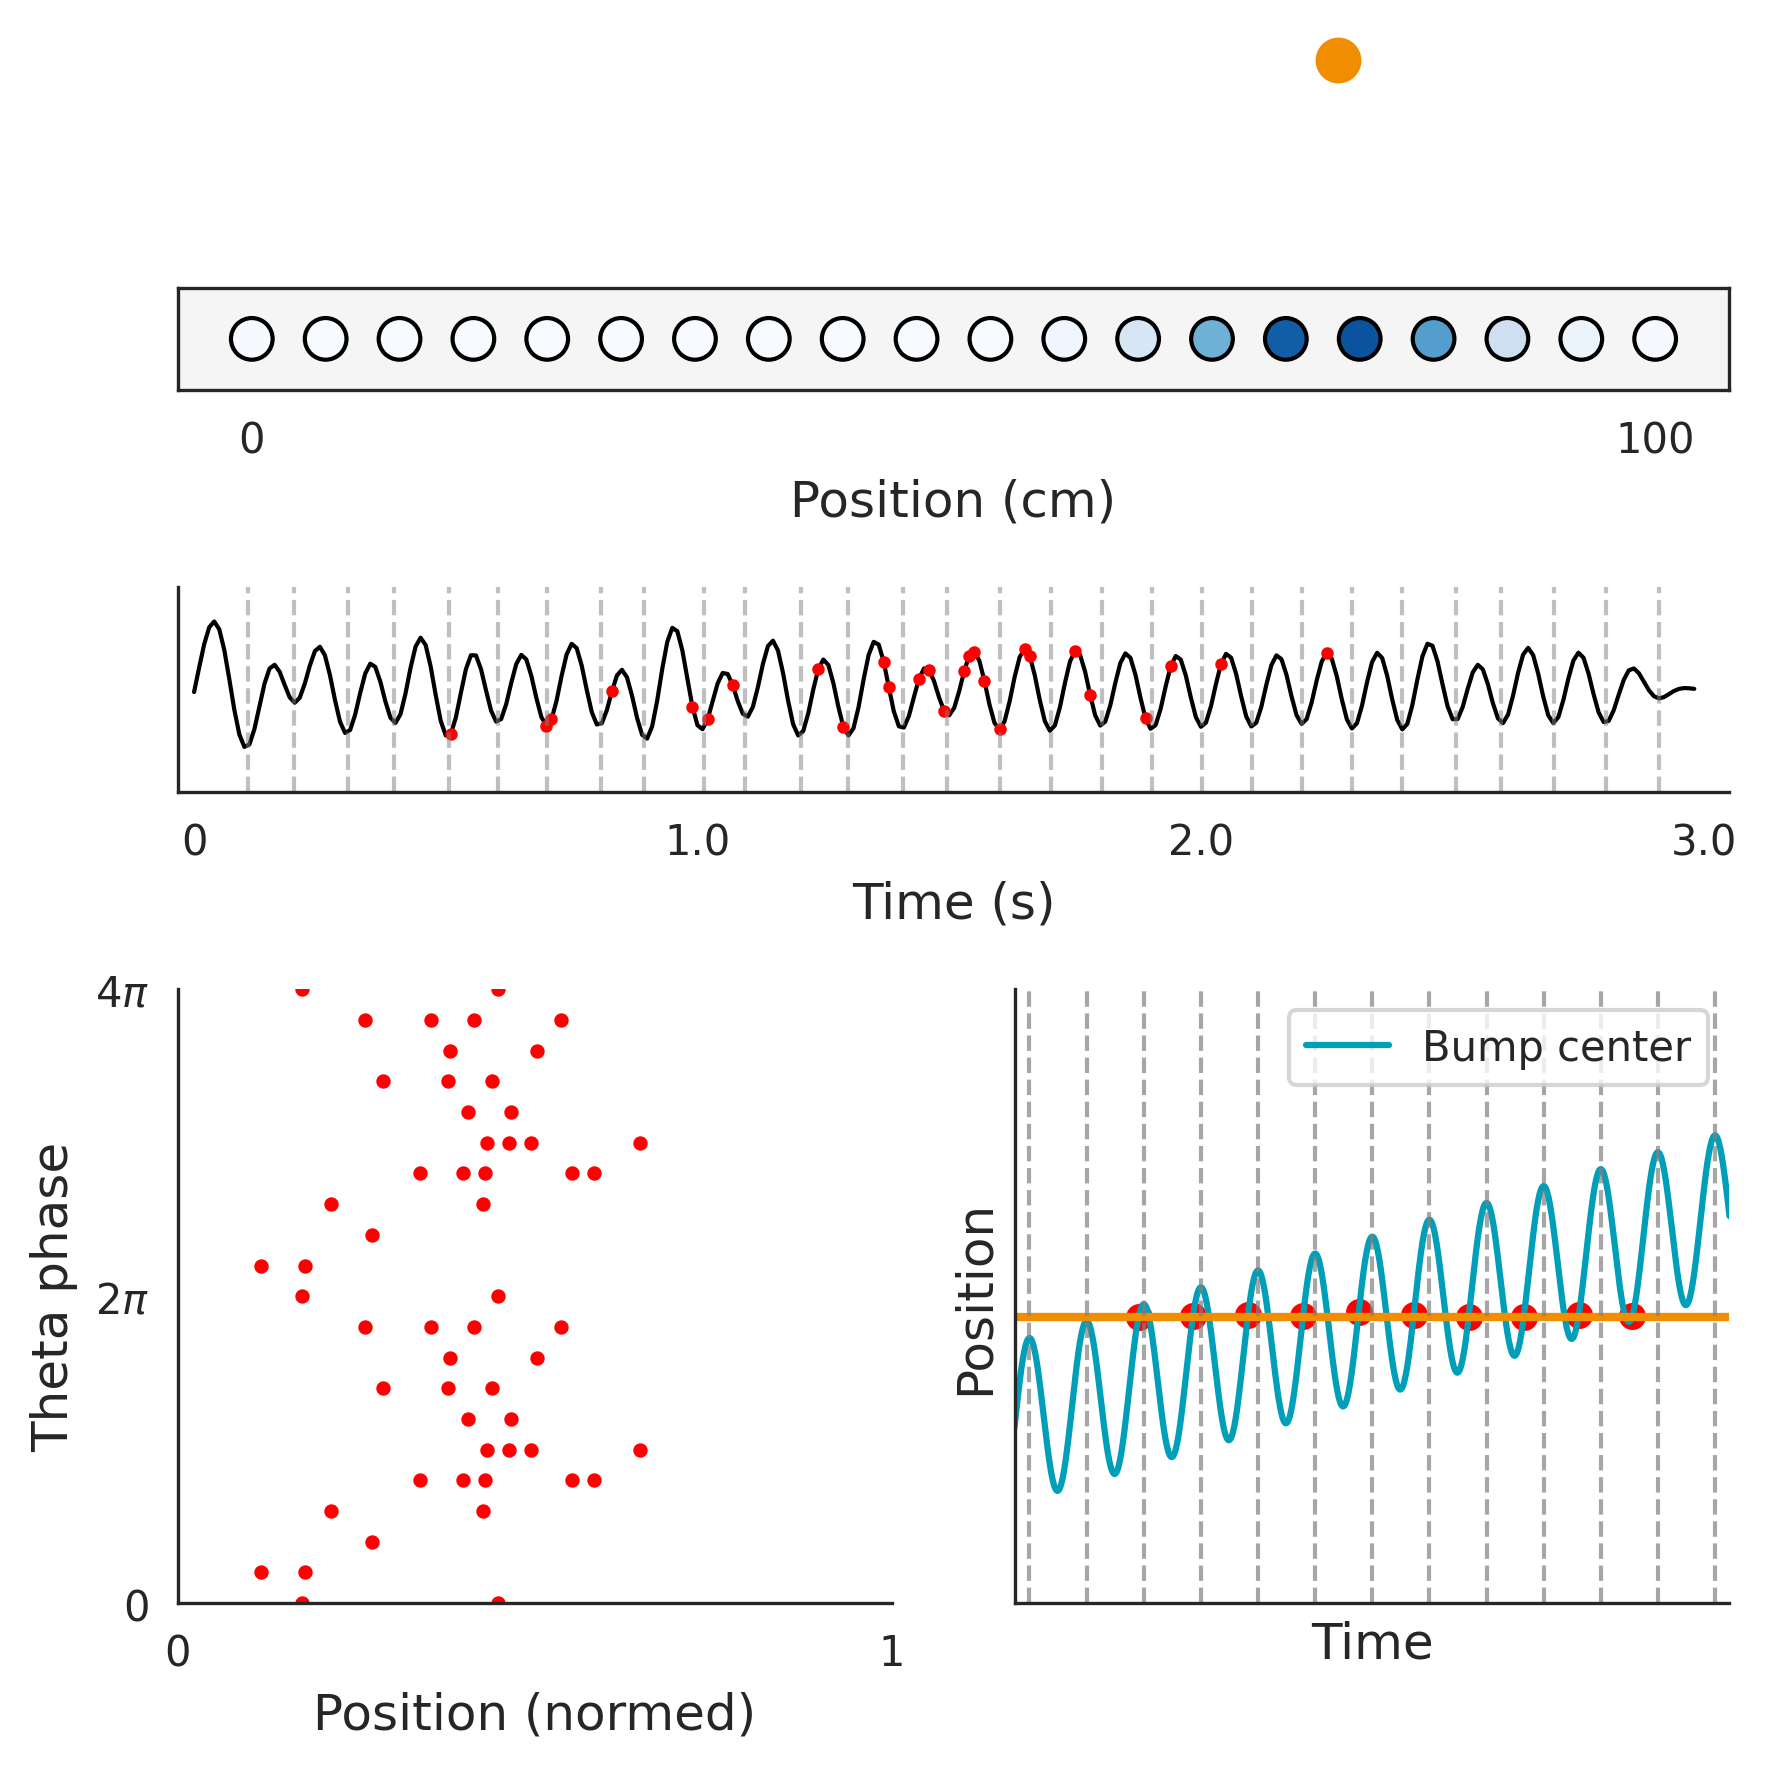

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import brainpy.math as bm
from scipy.signal import argrelextrema


np.random.seed(111)

# Simulation parameters
numT = 300  # Number of time steps
num_neurons = 200
downsample_factor = 10  # Downsample neurons (200 → 20)
num_downsampled_neurons = num_neurons // downsample_factor  # 20 neurons

# **Evenly Downsample bump activity** from (300, 200) → (300, 20)
bump_activity_downsampled = bump_activity_plot[:, np.linspace(0, num_neurons - 1, num_downsampled_neurons, dtype=int)]

# **Generate Poisson spikes for the 9th neuron**
cellindex = 9
selected_cell_activity = bump_activity_downsampled[:, cellindex]

pos_spike = []
tp_spike = []
spike_time = []
for i in range(len(Actual_pos_plot)):
    pos = Actual_pos_plot[i]
    tp = theta_phase_plot[i]
    r = selected_cell_activity[i]
    # Generate a Poisson spike event
    spikes = np.random.poisson(r, 1)
    if spikes > 0:
        pos_spike.append(pos)
        tp_spike.append(tp)
        spike_time.append(i)

# **Normalize Actual_pos_plot to match the neuron index range (0 to 19)**
actual_pos_normalized = np.interp(
    Actual_pos_plot, 
    (-np.pi, np.pi), 
    (0, num_downsampled_neurons - 1)
)

# **Set up figure**
fig = plt.figure(figsize=(6, 6), constrained_layout=True, dpi=300)
gs = fig.add_gridspec(4, 2, height_ratios=[0.3, 0.5, 1, 3], width_ratios=[1, 1])

# Left subplots
axes_pos = fig.add_subplot(gs[0, :])  # Top left (Theta modulation)
axes_cell = fig.add_subplot(gs[1, :])  # Bottom left (Population heatmap)
axes_theta = fig.add_subplot(gs[2, :])  # Bottom left (Theta oscillations)

# **Phase Precession Plot (axes_pp)**
axes_pp = fig.add_subplot(gs[3, 0])  # Position vs. Theta phase scatter plot
axes_schematic = fig.add_subplot(gs[3, 1])  # Schematic plot

# **Initialize position marker (Red dot for position tracking)**
pos_dot, = axes_pos.plot(actual_pos_normalized[0], 0, 'o', color="#F18D00", markersize=10)

# **Initialize scatter plot**
vmin = np.min(bump_activity_downsampled) 
vmax = np.max(bump_activity_downsampled) 
scatter = axes_cell.scatter(
    np.arange(num_downsampled_neurons),  # X-coordinates for neurons (flipped)
    np.zeros(num_downsampled_neurons),  # Y-coordinates fixed at 0
    c=np.zeros(num_downsampled_neurons),  # Initial colors
    cmap="Blues",  # Colormap
    s=100,  # Marker size
    edgecolors="black",
    vmin=vmin, vmax=vmax  # Color scale
)

# **Initialize theta oscillation plot**
axes_theta.set_ylim([-1.5*np.max(np.abs(theta)), 1.5*np.max(np.abs(theta))])
axes_theta.set_yticks([])

filtered_theta_line, = axes_theta.plot([], [], color='black', lw=1)

# **Initialize spike storage for theta oscillations**
spike_x = []
spike_y = []
spike_dot, = axes_theta.plot([], [], 'o', color="red", markersize=2)

# **Initialize Phase Precession Plot (Scatter for Spikes)**
spike_x_pp = np.array([])  # Store spike positions
spike_y_pp = np.array([])  # Store theta phases
scatter_pp = axes_pp.scatter([], [], s=6, color='red', alpha=1)

# **Plot phase lines**
for i in zero_phase_index:
    axes_theta.axvline(x=t_plot_raw[i], color='grey', linestyle='--', linewidth=1, alpha=0.5)


# Define parameters
time_schematic = np.linspace(0, 5, 2000)  # Time from 0 to 5 seconds
frequency = 5  # Hz
slope_factor = 2  # Reduce slope for slower ramping
position_schematic = (-3/4)*np.pi + (slope_factor/2)*np.pi * time_schematic/3 + np.sin(2 * np.pi * frequency * time_schematic)  # Slower ramping

# Find crossing points where position crosses y = 0
crossing_indices = np.where(np.diff(np.sign(position_schematic)))[0] + 1
crossing_times = time_schematic[crossing_indices]
crossing_positions = position_schematic[crossing_indices]

# **Keep only the odd zero crossings (first per cycle)**
odd_crossing_times = crossing_times[::2]
odd_crossing_positions = crossing_positions[::2]

# Find peaks (local maxima)
peak_indices = argrelextrema(position_schematic, np.greater)[0]
peak_times = time_schematic[peak_indices]
peak_positions = position_schematic[peak_indices]

# Create the plot
axes_schematic.plot(time_schematic, position_schematic, label="Bump center", color='#009FB9')

# Mark only the **odd** zero crossings
axes_schematic.scatter(odd_crossing_times, odd_crossing_positions, color='red', s=30)  # Red points at selected zero crossings

# Horizontal reference line at y=0
axes_schematic.axhline(y=0, color='#F18D00', linestyle='-', linewidth=2)

# Add vertical lines at the **peaks**
for t in peak_times:
    axes_schematic.axvline(x=t, color='grey', linestyle='--', linewidth=1, alpha=0.7)

# Styling
sns.despine(ax=axes_schematic)
axes_schematic.set_xlabel("Time", fontsize=12)
axes_schematic.set_ylabel("Position", fontsize=12)
axes_schematic.legend()

# Remove y and x ticks
axes_schematic.set_yticks([])
axes_schematic.set_xticks([])
axes_schematic.set_xlim(1, 3.5)

# **Axes settings**
axes_pos.set_xlim(0, num_downsampled_neurons - 1)  # Ensure red dot stays visible
axes_pos.set_xticks([])
axes_pos.set_yticks([])
axes_pos.set_frame_on(False)

axes_cell.set_xticks([])    
axes_cell.set_yticks([])
axes_cell.set_ylim(-1, 1)  # Scatter plot stays centered
axes_cell.set_xlim(-1, num_downsampled_neurons)  # Align neuron indices on x-axis
axes_cell.set_xticks([0, num_downsampled_neurons-1])
axes_cell.set_xticklabels([0, 100])
axes_cell.set_xlabel('Position (cm)', fontsize=12)

# **Set light grey background for axes_cell**
axes_cell.set_facecolor("whitesmoke")

axes_theta.set_xticks([start, 1000 + start, 2000 + start, 3000 + start])
axes_theta.set_xticklabels([0, 1.0, 2.0, 3.0])
axes_theta.set_xlabel("Time (s)", fontsize=12)

# **Phase Precession Axes Labels**
axes_pp.set_ylabel("Theta phase", fontsize=12)
axes_pp.set_xlabel("Position (normed)", fontsize=12)
axes_pp.set_xlim(-np.pi*2/3, np.pi*2/3)
axes_pp.set_ylim(-np.pi, 3 * np.pi)
axes_pp.set_xticks([-np.pi*2/3, np.pi*2/3])
axes_pp.set_xticklabels([0, 1])
axes_pp.set_yticks([-np.pi, np.pi, 3*np.pi])
axes_pp.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])

sns.despine(ax=axes_theta)
sns.despine(ax=axes_pp)

plt.tight_layout()

# **Animation update function**
def update(frame):
    global spike_x_pp, spike_y_pp  # Allow updating global spike arrays

    if frame == 0:
        return scatter, pos_dot, spike_dot, scatter_pp

    print(f"Frame: {frame} / {numT}")

    # **Update scatter colors based on bump activity at this time step**
    scatter.set_array(bump_activity_downsampled[frame, :])

    # **Update position dot (Red marker)**
    pos_dot.set_xdata(actual_pos_normalized[frame])

    # **Update theta modulation line**
    filtered_theta_line.set_data(t_plot[:frame], theta[:frame])

    # **Accumulate previous spikes and update spike plot**
    if frame in spike_time:
        spike_x.append(t_plot[frame])
        spike_y.append(theta[frame])
        
        # **Update Phase Precession Plot (axes_pp)**
        spike_x_pp = np.append(spike_x_pp, Actual_pos_plot[frame])
        spike_y_pp = np.append(spike_y_pp, theta_phase_plot[frame])

    spike_dot.set_data(spike_x, spike_y)  # Keep all past spike points
    
    # **Repeat scatter plot for 2π and 4π cycles**
    if spike_x_pp.size > 0:
        scatter_pp.set_offsets(np.column_stack((
            np.tile(spike_x_pp, 3),  # Repeat X (Position)
            np.concatenate([spike_y_pp, spike_y_pp + 2*np.pi, spike_y_pp + 4*np.pi])  # Repeat Y (Theta Phase)
        )))

    return scatter, pos_dot, spike_dot, scatter_pp

# **Create animation**
ani = animation.FuncAnimation(
    fig, update, frames=numT, interval=100, blit=True
)

# **Save animation as GIF**
ani.save("/home/zilong/Desktop/HDPhasePrecession/PrezFigures/phase_precession_model.gif",
         writer="ffmpeg", dpi=300)

plt.show()


### show Theta modulation and intrinsic oscillation of a cell

In [31]:
t_plot_raw.shape

(3000,)

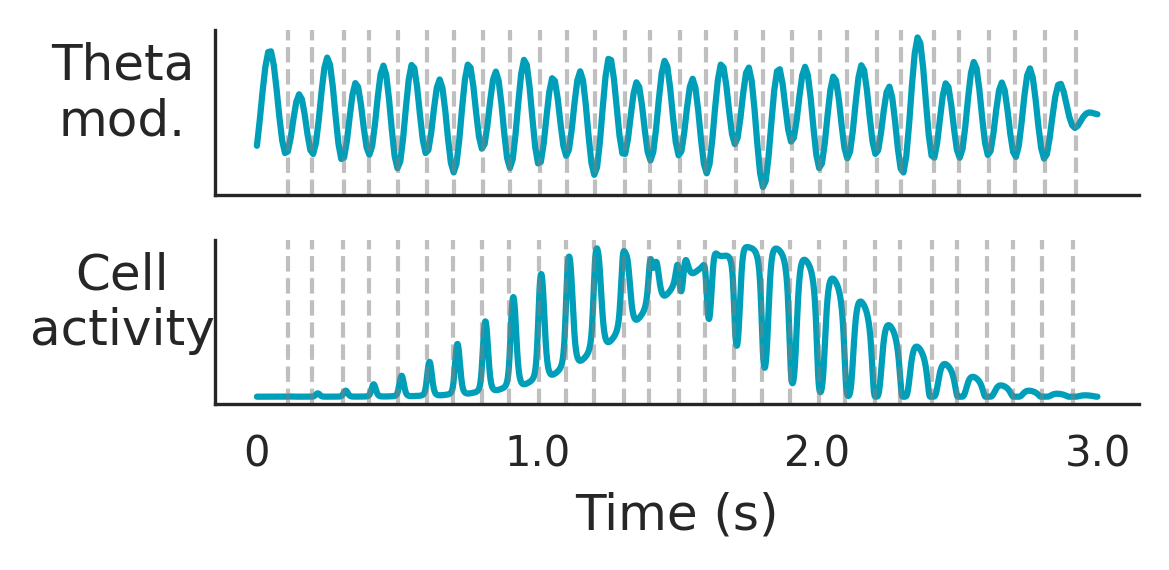

In [45]:
#activity of the 9th neuron
cellindex = 100
selected_cell_actvity = bump_activity[start:end, cellindex]*100


fig, axs = plt.subplots(2, 1, figsize=(4, 2), dpi=300)
# ax.plot(selected_cell_actvity)
# ax.plot(theta)
#nomralize the activity to -1 to 1
selected_cell_actvity = (selected_cell_actvity - np.min(selected_cell_actvity))/(np.max(selected_cell_actvity) - np.min(selected_cell_actvity))
#normalize theta to -1 to 1
theta = (theta - np.min(theta))/(np.max(theta) - np.min(theta))

axs[1].plot(t_plot_raw, selected_cell_actvity, label='Neuron activity', color='#009FB9')
axs[0].plot(t_plot,theta, label='Theta modulation', color='#009FB9')
#add vertical lines to indicate the zero phase
for i in zero_phase_index:
    axs[0].axvline(x=t_plot_raw[i], color='grey', linestyle='--', linewidth=1, alpha=0.5)
    axs[1].axvline(x=t_plot_raw[i], color='grey', linestyle='--', linewidth=1, alpha=0.5)

axs[0].set_ylabel('Theta\nmod.', fontsize=12, rotation=0)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_ylabel('Cell\nactivity', fontsize=12, rotation=0)
axs[1].set_xlabel('Time (s)', fontsize=12)
axs[1].set_xticks([start, 1000 + start, 2000 + start, 3000 + start])
axs[1].set_xticklabels([0, 1.0, 2.0, 3.0])
axs[1].set_yticks([])

#align ylabels vertically
axs[0].yaxis.set_label_coords(-0.10, 0.3)  # Shift labels left (adjust as needed)
axs[1].yaxis.set_label_coords(-0.10, 0.3)  # Shift labels left (adjust as needed)


sns.despine()

plt.tight_layout()

#save
plt.savefig('/home/zilong/Desktop/HDPhasePrecession/PrezFigures/intrinsic_oscillation.png')

### show the phase precession of a cell by simulating more laps

100%|██████████| 30000/30000 [00:00<00:00, 62942.95it/s]


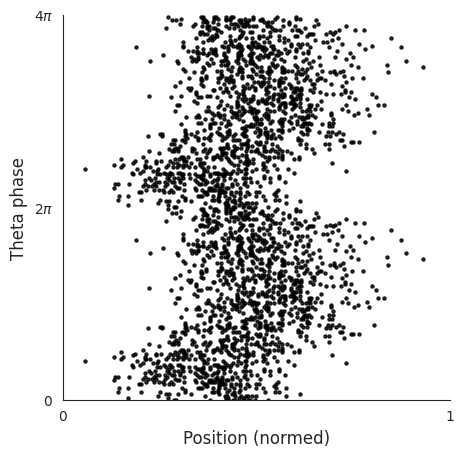

In [21]:
np.random.seed(1)

# Simulation parameters
numT = 30000
num_neurons = 200
downsample_factor = 10  # Downsample neurons (200 → 20)
num_downsampled_neurons = num_neurons // downsample_factor  # 20 neurons
time_steps = np.arange(numT)
velocity_gain = 1.3

# Generate head direction trajectory
Actual_pos = velocity_gain * bm.pi * bm.arange(numT) / 3000
Actual_pos = bm.mod(Actual_pos, 2 * bm.pi) - bm.pi
velocity_gain = np.ones_like(Actual_pos) * velocity_gain

# Run simulation
bump_center, bump_activity, theta_phase, theta_mod = bm.for_loop(run_PCNet, (time_steps, Actual_pos, velocity_gain), progress_bar=True)

bump_activity_downsampled = bump_activity[:, np.linspace(0, num_neurons - 1, num_downsampled_neurons, dtype=int)]

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

# ax = plot_phaseprecession(ax, 10, bump_activity_downsampled, Actual_pos, theta_phase)

cell_index = 10
activity = bump_activity_downsampled[:, cell_index]
pos_spike = []
tp_spike = []
#for each Head_direction, theta_phase pair, generate a spike event based on a Poisson process with mean value as r_HD
for i in range(len(Actual_pos)):
    pos = Actual_pos[i]
    tp = theta_phase[i]
    r = activity[i] 
    #genertae a spike event based on a Poisson process with mean value as r
    spikes = np.random.poisson(r, 1)
    if spikes > 0:
        #save hd and tp
        pos_spike.append(pos)
        tp_spike.append(tp)
pos_spike = np.array(pos_spike)
tp_spike = np.array(tp_spike)

ax.scatter(pos_spike, tp_spike, s=5, color='black', alpha=0.8)

ax.scatter(pos_spike, tp_spike+2*np.pi, s=5, color='black', alpha=0.8)


# ax[0].set_xlabel('Head direction')
ax.set_xlabel('Position (normed)', fontsize=12)
ax.set_ylabel('Theta phase', fontsize=12)
#activity colorbar
ax.set_xlim(-np.pi*2/3, np.pi*2/3)
ax.set_xticks([-np.pi*2/3, np.pi*2/3])
ax.set_xticklabels([0, 1])
ax.set_ylim(-np.pi, 3*np.pi)
ax.set_yticks([-np.pi, np.pi, 3*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])

#tick size
ax.tick_params(axis='both', which='major', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

